# A Fourier Perspective on Model Robustness
---

This notebook illustrates key ideas from the paper:

[ Yin, D., Gontijo Lopes, R., Shlens, J., Cubuk, E. D. & Gilmer, J. A Fourier Perspective on Model Robustness in Computer Vision. in Advances in Neural Information Processing Systems vol. 32 (Curran Associates, Inc., 2019). ](https://proceedings.neurips.cc/paper/2019/file/b05b57f6add810d3b7490866d74c0053-Paper.pdf)


Notebook Authors: Shawn Carer and Mohammadreza Moravej

## Setup
---

### Imports & Functions
---

#### Imports

In [ ]:
!pip install -q flax &> /dev/null
!pip install optax &> /dev/null

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import jax
import jax.numpy as jnp
import flax
from flax import linen as nn
from flax.training import train_state
import numpy as np
import optax
import tensorflow_datasets as tfds
import tqdm.notebook as tqdm
import time
from collections import defaultdict
import matplotlib.pyplot as plt
import dill
from typing import Any
import imageio
import scipy

#### Model

In [ ]:
class CNN(nn.Module):
  'A simple CNN network for image classification'

  num_classes: int

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(4, 4), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    
    x = nn.avg_pool(x, window_shape=(3, 3), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)

    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)

    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=128)(x)
    x = nn.relu(x)
    x = nn.Dense(features=self.num_classes)(x)
    x = nn.log_softmax(x)
    return x

class VGGblock(nn.Module):
  'A VGG Block'

  num_filters: int

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=self.num_filters, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.Conv(features=self.num_filters, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    return x

class VGG_baseline(nn.Module):
  'A small network with 3 VGG blocks and dropout'

  num_classes: int

  training: bool

  @nn.compact
  def __call__(self, x):
    x = VGGblock(num_filters=32)(x)
    x = nn.Dropout(rate=0.2)(x, deterministic = not self.training)
    x = VGGblock(num_filters=64)(x)
    x = nn.Dropout(rate=0.2)(x, deterministic = not self.training)
    x = VGGblock(num_filters=128)(x)
    x = nn.Dropout(rate=0.2)(x, deterministic = not self.training)
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=128)(x)
    x = nn.relu(x)
    x = nn.Dropout(rate=0.2)(x, deterministic = not self.training)
    x = nn.Dense(features=self.num_classes)(x)
    x = nn.log_softmax(x)
    return x

#### Misc Functions

In [ ]:
def get_dataset(dataset = 'cifar10'):
  'Loads cifar dataset into memory and splits into training and validation sets. Can set the datast to mnist'

  builder = tfds.builder(dataset)
  builder.download_and_prepare()
  train = tfds.as_numpy(builder.as_dataset(split='train', batch_size=-1))
  test = tfds.as_numpy(builder.as_dataset(split='test', batch_size=-1))
  train['image'] = jnp.float32(train['image']) / 255.0
  test['image'] = jnp.float32(test['image']) / 255.0
  return train, test

def init_train_state(model, input_shape, optimizer, rng):
  '''Creates a train state object from a model to be used during training
  
  Args:
    model (object): A flax model, subclassed from flax.linen.Module
    input_shape (sequence): The shape of the input data. Do not include the batch dimension
    optimizer (object): An optax optimizer object
    rng: A jax PRNG key to initialize model parameters with 
  '''
  input_shape = jnp.ones(jnp.insert(jnp.asarray(input_shape), 0, 1)) # Add an empty dim for batch dimension
  params = model.init(rng, input_shape)['params']
  state = train_state.TrainState.create(
      apply_fn=model.apply,
      params=params,
      tx=optimizer
  )
  return state


#### Loss and Metric Functions

In [ ]:
def cross_entropy_loss(y_true, y_pred):
  y_true = jax.nn.one_hot(y_true, num_classes=10)
  return -jnp.mean(jnp.sum(y_true * y_pred, axis=-1))

def accuracy(y_true, y_pred):
  return jnp.mean(jnp.argmax(y_pred, -1) == y_true, -1)

def get_metrics_fn(metric_functions):
  def metrics_fn(y_true, y_pred):
    out_dict = dict((fn.__name__, fn(y_true, y_pred)) for fn in metric_functions)
    return out_dict
  return metrics_fn

#### Eval Functions

In [ ]:
def get_eval_fn(model, loss_fn, metrics_fn=None):
  @jax.jit
  def jittable(batch, params):
    x_batch, y_batch = batch
    y_pred = model.apply({'params': params}, x_batch)
    loss = loss_fn(y_batch, y_pred)
    step_results = {'val_loss': loss}
    metrics = metrics_fn(y_batch, y_pred)
    metrics = dict(('val_' + key, metrics[key]) for key in metrics.keys())
    step_results.update(metrics)
    return step_results
  return jittable

def eval(data, params, eval_fn, batch_size=None, rng=None):
  """
  params is model weights 
  eval function is a function that returns all your metrics given batch of data and the weights
  """
  x, y = data
  if batch_size is None:
    num_batches = 1
    batch_indices = [jnp.arange(x.shape[0])] # all indices
  elif rng is None:
    raise ValueError('If you specify validation batch size you must also provide a jax PRNG key')
  else:
    num_batches = x.shape[0] // batch_size
    shuffle = jax.random.permutation(rng, x.shape[0])
    shuffle = shuffle[:num_batches*batch_size] # skip incomplete batch
    batch_indices = shuffle.reshape((num_batches, batch_size))

  eval_results = defaultdict(list)
 
  for batch_idx in batch_indices:
    batch = (x[batch_idx], y[batch_idx])
    step_results = eval_fn(batch, params)
    for key in step_results.keys(): eval_results[key].append(step_results[key])

  eval_results = jax.device_get(eval_results)
  eval_results = dict((key, np.mean(eval_results[key])) for key in eval_results.keys())

  return eval_results

#### Train Functions

In [ ]:
def get_train_step(model, loss_fn, metrics_fn):
  '''Performs a single train step for a model

  Args:
    batch: List or tuple containing the batch input data and the labels 
      eg (x_train, y_train)
    model: A flax model, subclassed from flax.linen.Module
    state: A flax TrainState object for the model
    loss_fn: A function that returns the loss for a batch of data given non-keyword 
      arguments y_true and y_pred in that specific order. Should return a single 
      loss value
    metrics_fn: A function that computes the desired metrics for a batch of data
      given non-keyword arguments y_true and y_pred in that specific order. 
      Should return a dictionary. Loss is already calculated and displayed by 
      default.
  '''
  @jax.jit
  def train_step(batch, state, rngs=None):
    def fwd_pass(params):
      y_pred = model.apply({'params': params}, batch[0], rngs=rngs)
      loss = loss_fn(y_true=batch[1], y_pred=y_pred)
      return loss, y_pred

    grad_fn = jax.value_and_grad(fwd_pass, has_aux=True)
    (loss, y_pred), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)

    batch_results = {'loss': loss}
    metrics = metrics_fn(batch[1], y_pred)
    batch_results.update(metrics)
    return state, batch_results
    
  return train_step

def train_epoch(data, state, train_step_fn, batch_size, rng, dropout=False, aug= None):
    x_train, y_train = data
    steps_per_epoch = x_train.shape[0] // batch_size
    shuffle = jax.random.permutation(rng, x_train.shape[0])
    shuffle = shuffle[:steps_per_epoch*batch_size] # skip incomplete batch for this epoch
    batch_indices = shuffle.reshape((steps_per_epoch, batch_size))
    epoch_results = defaultdict(list)
    if dropout:
        for batch_idx in batch_indices:
            rng, dropout_rng = jax.random.split(rng)
            x = apply_augmentation(x_train[batch_idx, ...], aug)
            batch = (x, y_train[batch_idx, ...])
            state, batch_results = train_step_fn(batch, state, rngs={'dropout': dropout_rng})
        for key in batch_results.keys(): epoch_results[key].append(batch_results[key])
    else:
        for batch_idx in batch_indices:
            x = apply_augmentation(x_train[batch_idx, ...], aug)
            batch = (x, y_train[batch_idx, ...])
            state, batch_results = train_step_fn(batch, state)
        for key in batch_results.keys(): epoch_results[key].append(batch_results[key])

    epoch_results = jax.device_get(epoch_results) # Don't fully understand what this does
    # calculate mean results for the epoch
    epoch_results = dict((key, np.mean(epoch_results[key])) for key in epoch_results.keys())
    return state, epoch_results

def train(data, model, optimizer, loss_fn, batch_size, epochs, rng, metrics_fn=None, validation_data=None, val_batch_size=None, verbosity='standard', dropout=False, aug = None):
  '''Generic function for training flax models

  Args:
    data: List or tuple containing the training data eg. (x_train, y_train)
    model: model: A flax model, subclassed from flax.linen.Module
    optimizer: An optimizer object from the optax library
    loss_fn: A function that returns the loss for a batch of data given non-keyword 
      arguments y_true and y_pred in that specific order. Should return a single 
      loss value
    batch_size: The number of samples in each batch
    epochs: The number of epochs to train the model for
    rng: A jax PRNG key. Used for randomization. 
    metrics_fn: A function that computes the desired metrics for a batch of data
      given non-keyword arguments y_true and y_pred in that specific order. 
      Should return a dictionary.
    validation_data: List or tuple containing the validation data. Model will be
      validated after every epoch
    verbosity (str): Either 'standard', 'quiet' or 'silent'. Standard displays
      the loss and metrics after each epoch. 'quiet' displays a tqdm loading bar.
      'silent' displays nothing except the final metrics at the end of training. 

    TODO: add a param for augmentation. Either apply the aug per epoch or apply it to the entire dataset at the beginning 
  '''
  x_train, y_train = data
  train_step = get_train_step(model, loss_fn, metrics_fn)
  eval_step = get_eval_fn(model, loss_fn, metrics_fn)
  if dropout:
    rng, params_rng, dropout_rng = jax.random.split(rng, 3)
    init_rng = {'params': params_rng, 'dropout': dropout_rng}
  else:
    rng, init_rng = jax.random.split(rng)
  state = init_train_state(model, x_train.shape[1:], optimizer, init_rng)

  if verbosity == 'quiet': 
    t = tqdm.trange(epochs) 
  else: 
    t = range(epochs)

  if metrics_fn is None:
    def metrics_fn(y_true, y_pred):
      return {}

  final_results = defaultdict(list) # Default dict makes it easier to append values
  for epoch in t:
    if dropout:
      model.training = True
    
    # Train Model
    rng, epoch_rng = jax.random.split(rng)
    ts = time.time()
    state, epoch_results = train_epoch(
        data=data, 
        state=state, 
        train_step_fn=train_step,
        batch_size=batch_size,
        rng=epoch_rng,
        dropout=dropout,
        aug=aug
        )
    te = time.time() - ts

    # Append results
    final_results['epoch'].append(epoch+1)
    for key in epoch_results.keys(): final_results[key].append(epoch_results[key])

    out_str = 'Epoch %.0f/%.0f, %.4fs -- ' % (epoch+1, epochs, te)
    out_str = out_str + ' '.join([' ' + metric + ': %.4f' % epoch_results[metric] for metric in epoch_results.keys()])
    if validation_data is not None:
      if dropout:
        model.training=False
      if val_batch_size is None:
        val_rng = None
      else:
        rng, val_rng = jax.random.split(rng)
      eval_results = eval(validation_data, state.params, eval_step, val_batch_size, val_rng)
      # Append results
      for key in eval_results.keys(): final_results[key].append(eval_results[key])

      out_str = out_str + ' - ' + ' '.join([' ' + metric + ': %.4f' % eval_results[metric] for metric in eval_results.keys()])
    if verbosity == 'standard':
      if epoch%10 == 0:
        print(out_str)

  print('Training Complete')
  if verbosity != 'standard':
    print(out_str)
  return state, final_results

#### Fourier Functions

In [ ]:
def fundamental_freq_2d(wavelength, n_rows, n_cols, angle=0, phase=0):
    '''Returns a 2d array representing the fundamental 2 dimensional 
    frequency/wavelength.

    Args:
    wavelength: The desired wavelength measured in pixels. Pass None to denote infinite wavelength/constant term
    n_rows: The resolution along the y-axis. It is best to use odd numbers
    n_cols: The resolution along the x-axis. It is best to use odd numbers
    angle: The angle of the wavelet measured in degrees
    phase: The phase shift of the wavelet measured in pixels

    Returns:
    wavelet: A 2d array containing the fundamental wavelet
    '''
    if wavelength is None:
        return jnp.ones((n_rows, n_cols))
    
    x = jnp.arange(-int(n_cols/2), n_cols - int(n_cols/2), 1)
    y = jnp.arange(-int(n_rows/2), n_cols - int(n_rows/2), 1)

    X, Y = jnp.meshgrid(x, y)
    #angle = 2*jnp.pi*angle/360.0 # convert angle to radians
    X_prime = X*jnp.cos(angle) +  Y*jnp.sin(angle)
    wavelet = jnp.sin((2 * jnp.pi/ wavelength) * (X_prime + phase))

    return wavelet

def img_2_ft(img):
  "takes an image in and returns the Foriuer transform (in cartesian coordinates, in the paper they had the amplitude)"
  ft = jnp.fft.ifftshift(img)
  ft = jnp.fft.fft2(ft)
  return jnp.fft.fftshift(ft)

def ft_2_img(ft):
  '''Goes from frequency domain to image domain. ft must be in cartesian coordinates'''
  ift = jnp.fft.ifftshift(ft)
  ift = jnp.fft.ifft2(ift)
  ift = jnp.fft.fftshift(ift)
  return ift.real 

def cart_2_pol(data):
  '''Takes a complex number in cartesian coordinates as input and returns the amplitude and phase'''
  return abs(data), jnp.angle(data)

def get_r_theta(i, j, shape):
    '''Takes a number in cartesian coordinates as input and returns the amplitude and phase'''
    center = shape[0]//2 + 1, shape[1]//2 + 1
    r = ((i-center[0])**2 + (j-center[1])**2)**0.5
    return r, jnp.arctan2(i - center[0], j - center[1])

def pol_2_cart(r, theta):
  real = r * jnp.cos(theta)
  im = r * jnp.sin(theta)
  return r + 1j * im

#@jax.jit
def add_freq_noise(images, wavelength, angle, rng = jax.random.PRNGKey(10), norm=1, phase=0, channels=3):
    """Given the validation dataset, and a noise, apply the noise to every image in the dataset
    Each image gets a noise with a random amplitute
    We follow the same process as the paper:
    X_i,j = r*v*U_i,j , where v = 1, r is uniform_sample
    # U_i,j is the Fourier basis matrix of the wave 
    """
    n_rows = images.shape[1]
    n_cols = images.shape[2]
    dataset_size = images.shape[0]
    rng, newkey = jax.random.split(rng)
    uniform_sample = jax.random.uniform(newkey, shape = (dataset_size, 1, 1, channels))
    fb = jnp.reshape(fundamental_freq_2d(wavelength, n_rows=n_rows, n_cols=n_cols, angle=angle, phase=0), (1, n_rows, n_cols, 1))
    fb = fb / jnp.linalg.norm(fb, axis=(1, 2)) # Set norm of basis vector to 1
    fb = jnp.broadcast_to(fb, (1, n_rows, n_cols, channels))
    noise = uniform_sample * fb
    output_images = images + norm*noise
    return output_images


def add_freq_noise_phase(images, wavelength, angle, rng=jax.random.PRNGKey(10), norm=1, channels=3):
    """Given the validation dataset, and a noise, apply the noise to every image in the dataset
    Each image gets a noise with a random amplitute
    The noise being specified by (wavelength, angle) applied to each image has the same phase as the basis vector of the image at (wavelength, angle)
    """
    n_rows = images.shape[1]
    n_cols = images.shape[2]
    print(images.shape)
    dataset_size = images.shape[0]
    rng, newkey = jax.random.split(rng)
    uniform_sample = jax.random.uniform(newkey, shape = (dataset_size, 1, 1, channels))
    fb = np.zeros((1, n_rows, n_cols, 1))
    for i, image in enumerate(images):
        ft = img_2_ft(img)
        r, p = cart_2_pol(ft)
        fb[i] = jnp.reshape(fundamental_freq_2d(wavelength, n_rows=n_rows, n_cols=n_cols, angle=angle, phase=p), (n_rows, n_cols, 1))
    fb = fb / jnp.linalg.norm(fb, axis=(1, 2)) # Set norm of basis vector to 1
    fb = jnp.broadcast_to(fb, (images.shape[0], n_rows, n_cols, channels))
    noise = uniform_sample * fb
    output_images = images + norm*noise
    return output_images

def apply_filter(dataset, filter='low_pas', sigma=2): 
    """
    Applies filter to every image in the dataset. Returns the new dataset. 
    Used for reproducing Fig 1
    filter is either "low_pass" or "high_pass"
    """  
    x_dataset, t_dataset = dataset
    new_x_dataset = np.ndarray(x_dataset.shape)
    alpha = 20
    i = 0
    sigma2 = 2
    img = x_dataset[0]
    
    if filter == "high_pass":
      def f(img):
         #blurred_img = np.expand_dims(ndimage.gaussian_filter(np.squeeze(img), sigma), 2) #if using MNIST
         blurred_img = ndimage.gaussian_filter(img, sigma)
         filter_blurred_img = ndimage.gaussian_filter(blurred_img, sigma2)
         return blurred_img + alpha * (blurred_img - filter_blurred_img)
    else: #filter == "low_pass":
      def f(img):
         #return np.expand_dims(ndimage.gaussian_filter(np.squeeze(img), sigma), 2) #if using MNIST
         return ndimage.gaussian_filter(img, sigma)

    for img in x_dataset:
      #new_x_dataset.at[i].set(new_x)
      new_x_dataset[i] = f(img)
      i += 1
        
    return new_x_dataset, t_dataset


def apply_augmentation(x_dataset, aug = None): 
    """
    Applies augmentation to every images in the dataset
    aug: augmentation type 
    """  
    
    mu, sigma = 0, 0.1 # mean and standard deviation of guassian noise, same values as the paper
    i = 0
    degrees = 45 # the rotation degree for rotation augmentation

    if aug == "guassian":
      noise = np.random.normal(mu, sigma, x_dataset.shape)
      return noise + x_dataset

    elif aug == "rotate":
      return ndimage.rotate(x_dataset, 45, axes=(1, 2), reshape=False)
        
    return x_dataset


### Model Training
---

In [ ]:
train_data, test_data = get_dataset()
# Crop images to have odd dimensions to make it easier to interpret fourier transforms
x_train = train_data['image'][:, :-1, :-1, :]
y_train = train_data['label']
x_test = test_data['image'][:, :-1, :-1, :]
y_test = test_data['label']

In [ ]:
skip_training = False
if not skip_training:
  model = VGG_baseline(num_classes=10, training=True)
  #model = CNN(num_classes=10)
  opt = optax.adam(learning_rate=0.0001)
  #opt = optax.sgd(learning_rate=0.001, momentum=0.9)
  seed=0
  main_key = jax.random.PRNGKey(seed)
  metric_fn = get_metrics_fn(metric_functions=[accuracy])

  main_key, train_key = jax.random.split(main_key)
  state, results = train(
      data=(x_train, y_train),
      model=model,
      optimizer=opt,
      loss_fn=cross_entropy_loss,
      batch_size=64,
      epochs=51,
      rng=train_key,
      validation_data=(x_test, y_test),
      val_batch_size=None,
      metrics_fn=metric_fn,
      verbosity='standard',
      dropout=True
  )

Epoch 1/51, 4.1042s --  accuracy: 0.2500  loss: 1.9629 -  val_accuracy: 0.4034  val_loss: 1.6572
Epoch 11/51, 2.9404s --  accuracy: 0.7031  loss: 0.8450 -  val_accuracy: 0.6784  val_loss: 0.9075
Epoch 21/51, 2.9402s --  accuracy: 0.7500  loss: 0.7625 -  val_accuracy: 0.7453  val_loss: 0.7362
Epoch 31/51, 2.9407s --  accuracy: 0.8906  loss: 0.4012 -  val_accuracy: 0.7750  val_loss: 0.6441
Epoch 41/51, 2.9413s --  accuracy: 0.8594  loss: 0.4351 -  val_accuracy: 0.7928  val_loss: 0.6122
Epoch 51/51, 2.9400s --  accuracy: 0.8438  loss: 0.4857 -  val_accuracy: 0.8009  val_loss: 0.6048
Training Complete


In [ ]:
model_name = 'cifar_50epoch'
with open('/content/drive/MyDrive/CSC2541/' + model_name + '_params.pkl', 'wb') as file:
  dill.dump(state.params, file)
with open('/content/drive/MyDrive/CSC2541/' + model_name + '_arch.pkl', 'wb') as file:
  dill.dump(model, file)

In [ ]:
model_name = 'cifar_50epoch_params.pkl'

with open('/content/drive/MyDrive/CSC2541/' + model_name, 'rb') as file:
     params = dill.load(file)
    
print(params.keys())

frozen_dict_keys(['Dense_0', 'Dense_1', 'VGGblock_0', 'VGGblock_1', 'VGGblock_2'])


## Start Here
---

### Intro to 2d Fourier

We first give a breif overview of 2d Fourier.  A wave can be represented by the following equation:

$ y = A sin(\frac{2\pi x}{λ} + \phi)$

Where $A$ is the amplitude, $\lambda$ is the wavelength, and $\phi$ is the phase. A sinusoidal grating is a two-dimensional representation of a wave in which the amplitude changes sinusoidally along a direction.

Given a wave (or a grating in 2d), the Fourier function is a function that breaks the wave down into a set of $\textit{basis}$ waves. The Fourier function thus gives us a $\textit{Fourier basis}$ for a specific wave. More formally, the 2d Fourier is a map $F: \mathbf{R}^{d_1 \times d_2} → \mathbf{C}^{d_1 \times d_2}$. Given an input matrix $X \in \mathbf{R}^{d_1 \times d_2}$, $F(X)$ maps $X$ to a $d_1 \text{by} d_2$ array of complex numbers.

Each entry of $X$ (representing a grating) is a complex number. This is because any wave grating can be represented by a complex number $|r| (cos \theta + \text{i } sin \theta)$ in polar coordinates. The angel $\theta$ will represent the direction of the wave. The radius $r$ represenets the frequency $\frac{1}{\lambda}$ of the wave.

You can make a grating below and see the representation of the wave as a complex number.


In [ ]:
wavelength = 8 #@param {type:"slider", min:1, max: 12, step:1}
angle = 0 #@param {type:"slider", min:0, max: 6.28, step:0.1}
phase = 0 #@param {type:"slider", min:0, max:1, step:0.1}
amplitude =  0.4 #@param {type:"slider", min:0, max:1, step:0.1}

grating = amplitude * fundamental_freq_2d(wavelength, 51, 51, angle, phase)

plt.set_cmap("gray")
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(grating)

pixel = img_2_ft(grating)
plt.subplot(1, 2, 2)
plt.imshow(abs(pixel))

plt.show()

The orientation of the dots represents the orientation (angle) of the grating.

The distance of the dots from the centre represents the frequency of the sinusoidal grating.

The value of the pixels making up the dots in the Fourier transform represent the amplitude of the grating.

Information about the phase is encoded in the complex component of the Fourier transform. Notice that changing the phase does not affect the image on the right. This is beacuse we are displaying the amplitude of the fourier transform. Both the amplitude and phase can not be visualized at the same time in 2 dimensions

The Fourier transform is a linear and invertible map. Below we add two different grating together. The result is shown in the third row:

<Figure size 432x288 with 0 Axes>

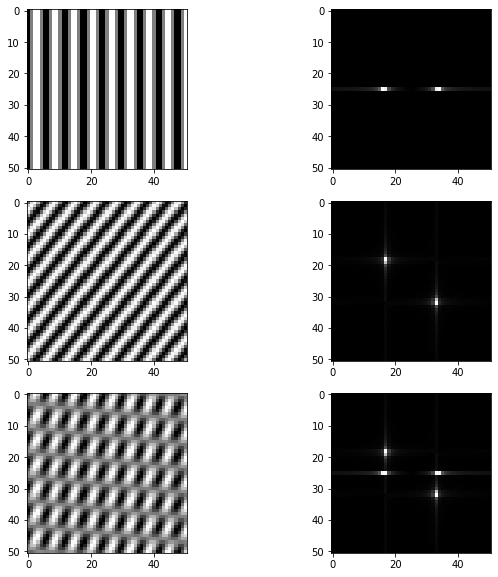

In [ ]:
wavelength1 = 6 #@param {type:"slider", min:1, max: 12, step:1}
angle1 = 0 #@param {type:"slider", min:0, max: 6.28, step:0.1}
phase1 = 0 #@param {type:"slider", min:0, max:1, step:0.1}
amplitude1 =  1 #@param {type:"slider", min:0, max:1, step:0.1}

wavelength2 = 5 #@param {type:"slider", min:1, max: 12, step:1}
angle2 = 0.7 #@param {type:"slider", min:0, max: 6.28, step:0.1}
phase2 = 0.1 #@param {type:"slider", min:0, max:1, step:0.1}
amplitude2 =  1 #@param {type:"slider", min:0, max:1, step:0.1}

grating1 = amplitude * fundamental_freq_2d(wavelength1, 51, 51, angle1, phase1)
grating2 = amplitude * fundamental_freq_2d(wavelength2, 51, 51, angle2, phase2)

plt.set_cmap("gray")
plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.imshow(grating1)
pixel = img_2_ft(grating1)
plt.subplot(3, 2, 2)
plt.imshow(abs(pixel))

plt.subplot(3, 2, 3)
plt.imshow(grating2)
pixel = img_2_ft(grating2)
plt.subplot(3, 2, 4)
plt.imshow(abs(pixel))

plt.subplot(3, 2, 5)
plt.imshow(grating1 + grating2)
pixel = img_2_ft(grating1 + grating2)
plt.subplot(3, 2, 6)
plt.imshow(abs(pixel))

plt.show()

### Mnist Example

We now take a look at MNIST images. The second row contrains the Fourier transform of the images. The third row contains the Fourier transform of the images, except the value of the pixels making up the dots in the Fourier transform represent the phase (instead of the amplitude) of the grating.

In [ ]:
mnist_train_data, mnist_test_data = get_dataset('mnist')

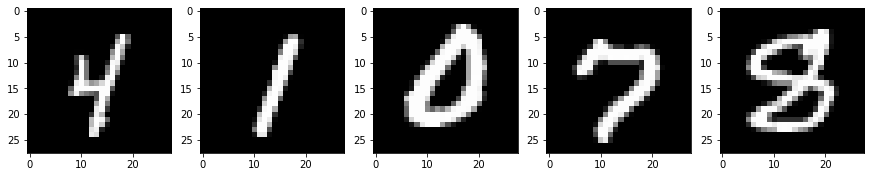

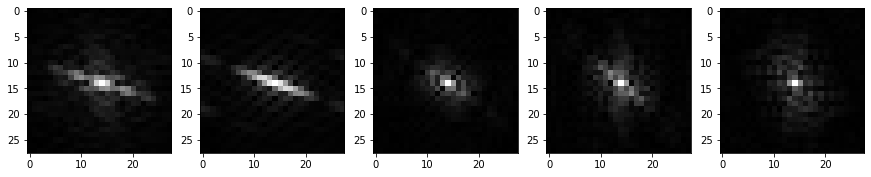

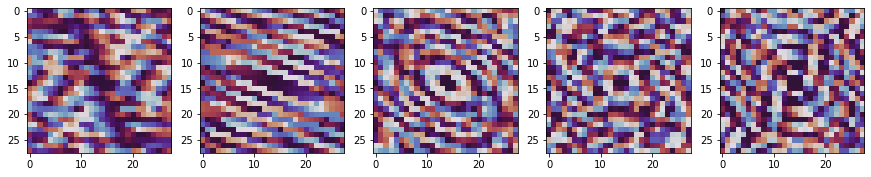

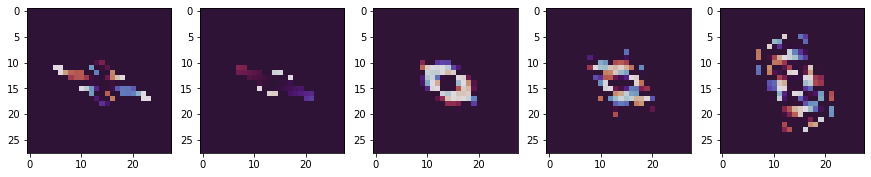

In [ ]:
fts = []
rs = []
ps = []
p_masked = []
masks = []
for i in range(5):
  ft = img_2_ft(np.squeeze(mnist_train_data['image'][i]))
  r, p = cart_2_pol(ft)
  fts.append(ft)
  rs.append(r)
  ps.append(p)
  mask = r > 10
  masks.append(mask)
  p_masked.append((p)*mask)

plt.figure(figsize=(15, 3))
plt.set_cmap('gray')
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(np.squeeze(mnist_train_data['image'][i]))

plt.figure(figsize=(15, 3))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(rs[i])
#plt.colorbar()

plt.figure(figsize=(15, 3))
plt.set_cmap('twilight')
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(ps[i])

plt.figure(figsize=(15, 3))
plt.set_cmap('twilight')
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(p_masked[i])
#plt.colorbar()
plt.show()






### The Robustness Problem
---
$\textit{In this section, we motivate the problem and reproduce some of the results from Fig 1 in the paper.}$


Models often perform poorly in the presence of subtle distributional shifts. We reproduce the results from the paper to show that this is due to the model relying on a $\textit{sufficient and non-robust subset of features}$. There are many correlations between the input and target that models can utilize to generalize well. The downside of utilizing such sufficient statistics is dramatic reduction in model performance if these same statistics get corrupted at test time.

Below, we experiment with extreme filtering in order to test the limits of model generalization. We show that the model relies on high and low frequency features (which are nearly invisible to humans) and thus gets high accuracy on images with extreme filtering. 

For computational purposes, we only apply a highpass and lowpass noises. Refer to Fig 1 for a more complete set of results.

In [ ]:
train_data, test_data = get_dataset()

In [ ]:
# apply highpass and lowpass filters to the validation data

validation_data=(x_test, y_test)
data_highpass1 = apply_filter(validation_data, 'high_pass', 0.5)
data_highpass2 = apply_filter(validation_data, 'high_pass', 1)
data_highpass3 = apply_filter(validation_data, 'high_pass', 2)
data_lowpass1 = apply_filter(validation_data, 'low_pass', 0.5)
data_lowpass2 = apply_filter(validation_data, 'low_pass', 1)
data_lowpass3 = apply_filter(validation_data, 'low_pass', 2)

In [ ]:
val_accuracies = []
val_losses = []
filter_size = []
# calculate the width of filter applied to each dataset given sigma and truncate (truncate is 4)
#filter_width = [2*int(4*0.5 + 0.5) + 1, 2*int(4*1 + 0.5) + 1, 2*int(4*2 + 0.5) + 1, 2*int(4*0.5 + 0.5) + 1, 2*int(4*1 + 0.5) + 1, 2*int(4*2 + 0.5) + 1]
val_datasets = [validation_data, data_highpass1, data_highpass2, data_highpass3, data_lowpass1, data_lowpass2, data_lowpass3]
metric_fn = get_metrics_fn(metric_functions=[accuracy])
eval_step = get_eval_fn(model, cross_entropy_loss, metric_fn)

for i in range(7):
  val_results = eval(val_datasets[i], state.params, eval_step, None, random.PRNGKey(10))
  val_losses.append(val_results['val_loss'])
  val_accuracies.append(val_results['val_accuracy'])


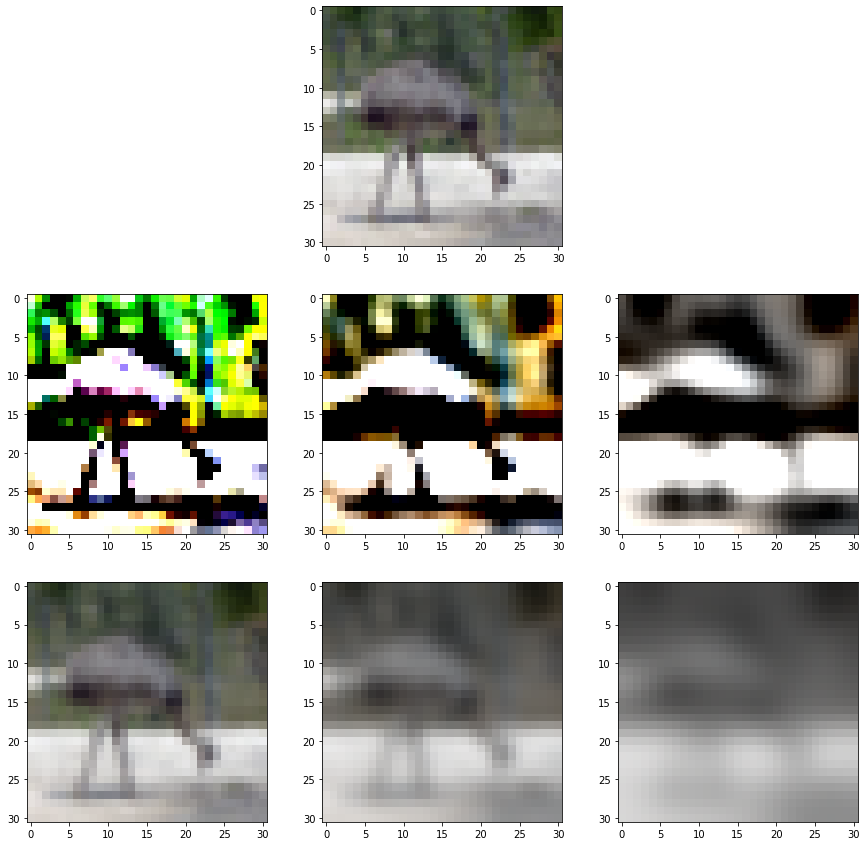

In [ ]:
imges = [val_datasets[0][0][9], val_datasets[1][0][9], val_datasets[2][0][9], val_datasets[3][0][9], val_datasets[4][0][9], val_datasets[5][0][9],
         val_datasets[6][0][9]]

fig = plt.figure(figsize=(15, 15))

plt.subplot(3, 3, 2)
plt.imshow(imges[0])

plt.subplot(3, 3, 4)
plt.imshow(imges[1])

plt.subplot(3, 3, 5)
plt.imshow(imges[2])

plt.subplot(3, 3, 6)
plt.imshow(imges[3])

plt.subplot(3, 3, 7)
plt.imshow(imges[4])

plt.subplot(3, 3, 8)
plt.imshow(imges[5])

plt.subplot(3, 3, 9)
plt.imshow(imges[6])


We train the model on a dataset with no applied noise. The picture on the top is an exmaple from the origianl dataset. We then test the model on datasets with extreme filtering. 

The second row contains the same images from three datasets where high-pass filtering has been applied. The rightmost image is sampled from the dataset with the most extreme filtering and the leftmost one is sampled from a dataset where the flitering was not as extreme. The third row includes the same images, except the filter applied to the datasets is low-pass. 

The rightmost images are not recognizable by the human eye and do not contain any indicative features of an ostrich. However, the model is still able to get a decent accuracy when tested on datasets with such high noise. 

Run the cell below to get the accuracies:

In [ ]:
print('test accuracy on the original (natural) dataset: ', val_accuracies[0])
print('test accuracy on the datasets with high-filter noise (second row, from left to right): ', val_accuracies[1:4])
print('test accuracy on the datasets with high-filter noise (third row, from left to right): ', val_accuracies[4:7])

test accuracy on the original (natural) dataset:  0.8009
test accuracy on the datasets with high-filter noise (second row, from left to right):  [0.5126, 0.51919997, 0.3901]
test accuracy on the datasets with high-filter noise (third row, from left to right):  [0.7787, 0.3987, 0.2101]


### Paper Results: Model Sensitivity to Different Frequencies
---

The previous section demonstrated that both low and high frequency features play a role for classification. It is natural to hypothesize that data augmentation may bias the model towards utilizing different kinds of features in classification.

Next, we experimnet with model sensitivity to additive noise aligned with different Fourier basis vectors on CIFAR-10 to confirm the above hypothesis. Our results replacate Fig 3 from the paper. We also include an additional plot for augmentation with rotation.

In [ ]:
skip_training=False

# Train the model on Gussian augmented data 
if not skip_training:
  model1 = VGG_baseline(num_classes=10, training=True)
  #model = CNN(num_classes=10)
  opt = optax.adam(learning_rate=0.0001)
  #opt = optax.sgd(learning_rate=0.001, momentum=0.9)
  seed=0
  main_key = jax.random.PRNGKey(seed)
  metric_fn = get_metrics_fn(metric_functions=[accuracy])

  main_key, train_key = jax.random.split(main_key)
  state2, results2 = train(
      data=(x_train, y_train),
      model=model1,
      optimizer=opt,
      loss_fn=cross_entropy_loss,
      batch_size=64,
      epochs=51,
      rng=main_key,
      validation_data=(x_test, y_test),
      val_batch_size=None,
      metrics_fn=metric_fn,
      verbosity='standard',
      dropout=True,
      aug='guassian'
  )


Epoch 1/51, 9.2270s --  accuracy: 0.3594  loss: 1.8331 -  val_accuracy: 0.3624  val_loss: 1.7510
Epoch 11/51, 8.0340s --  accuracy: 0.5312  loss: 1.1017 -  val_accuracy: 0.6333  val_loss: 1.0406
Epoch 21/51, 8.0067s --  accuracy: 0.7500  loss: 0.7259 -  val_accuracy: 0.6894  val_loss: 0.8809
Epoch 31/51, 7.9852s --  accuracy: 0.7500  loss: 0.6028 -  val_accuracy: 0.7282  val_loss: 0.7765
Epoch 41/51, 8.1502s --  accuracy: 0.6875  loss: 0.7104 -  val_accuracy: 0.7440  val_loss: 0.7460
Epoch 51/51, 8.1868s --  accuracy: 0.7656  loss: 0.5977 -  val_accuracy: 0.7421  val_loss: 0.7671
Training Complete


In [ ]:
skip_training=False

# Train the model on data augmented with rotation 
if not skip_training:
  model2 = VGG_baseline(num_classes=10, training=True)
  #model = CNN(num_classes=10)
  opt = optax.adam(learning_rate=0.0001)
  #opt = optax.sgd(learning_rate=0.001, momentum=0.9)
  seed=0
  main_key = jax.random.PRNGKey(seed)
  metric_fn = get_metrics_fn(metric_functions=[accuracy])

  main_key, train_key = jax.random.split(main_key)
  state3, results3 = train(
      data=(x_train, y_train),
      model=model2,
      optimizer=opt,
      loss_fn=cross_entropy_loss,
      batch_size=64,
      epochs=51,
      rng=main_key,
      validation_data=(x_test, y_test),
      val_batch_size=None,
      metrics_fn=metric_fn,
      verbosity='standard',
      dropout=True
  )


Epoch 1/51, 4.4378s --  accuracy: 0.3594  loss: 1.7994 -  val_accuracy: 0.4144  val_loss: 1.6169
Epoch 11/51, 3.0418s --  accuracy: 0.6562  loss: 0.9185 -  val_accuracy: 0.6948  val_loss: 0.8626
Epoch 21/51, 2.9469s --  accuracy: 0.7812  loss: 0.6064 -  val_accuracy: 0.7582  val_loss: 0.7022
Epoch 31/51, 2.9396s --  accuracy: 0.7969  loss: 0.5536 -  val_accuracy: 0.7726  val_loss: 0.6607
Epoch 41/51, 2.9410s --  accuracy: 0.8438  loss: 0.4166 -  val_accuracy: 0.7979  val_loss: 0.5953
Epoch 51/51, 3.0868s --  accuracy: 0.9375  loss: 0.2447 -  val_accuracy: 0.8006  val_loss: 0.6009
Training Complete


In [ ]:
y_pred = model.apply({'params': params}, x_test)

In [ ]:
model = VGG_baseline(num_classes=10, training=False)
loss_fn=cross_entropy_loss
metric_fn = get_metrics_fn(metric_functions=[accuracy])
eval_step = get_eval_fn(model, loss_fn, metric_fn)

model_states = [state, state2, state3]
heat_maps = []

shape = (x_test.shape[1], x_test.shape[2])
r = np.zeros(shape)
a = np.zeros(shape)
w = np.zeros(shape)

n = []
validation_data=(test_data['image'], test_data['label'])

def generate_heatmap(data, model, params, norm=None):
    x_eval, y_eval = data
    img = np.ndarray((x_eval[0].shape[0], x_eval[0].shape[1]))
    for row in tqdm.trange(img.shape[0]):
        for column in range(img.shape[1]):
            radius, angle = get_r_theta(row, column, img.shape)
            wavelength = img.shape[0]/radius if radius != 0 else None #the middel pixel
            new_eval_images = add_freq_noise(x_eval, wavelength, angle, norm=1, rng = jax.random.PRNGKey(10), phase=0)
            eval_results = eval((new_eval_images, y_eval), params, eval_step, batch_size=None, rng=jax.random.PRNGKey(10))
            img[row, column] = eval_results['val_accuracy']
            r[row, column] = radius
            a[row, column] = angle
            w[row, column] = wavelength
    heat_maps.append(img)
    return img


data = (x_test[0:1000], y_test[0:1000]) #error rates are averaged 100 validation images
for model_state in model_states:
  generate_heatmap(data, model, model_state.params)


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

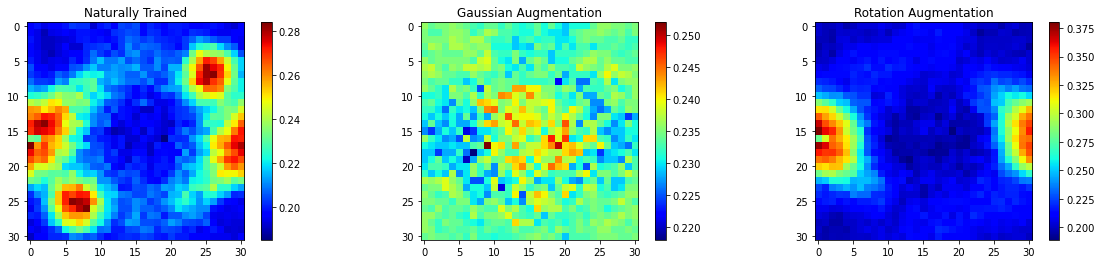

In [ ]:
plt.figure(figsize=(20, 4))

plt.subplot(1, 3, 1)
plt.imshow(1 - heat_maps[0])
plt.title('Naturally Trained')
plt.set_cmap('jet')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(1 - heat_maps[1])
plt.title('Gaussian Augmentation')
plt.set_cmap('jet')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(1 - heat_maps[2])
plt.title('Rotation Augmentation')
plt.set_cmap('jet')
plt.colorbar()
plt.show()


We reproduce the heatmap generated in Figure 3 of the paper. 
We train the model on three different datasets; a natural dataset , a gussian augmented dataset and a dataset augmented by a 45 degree rotation .
Our results are coherent with the findings of the paper. We make the following remarks:
- The naturally trained model is particularly sensitive to a ring of medium frequencies. It is particularly sensitive to directions that are vertical and slightly less so on a 45 degree angle.
- The model trained on Gaussian data has worse performance overall, but becomes more sensitive to the low frequencies and less sensitive to that ring of higher frequencies. Hence, the gaussian filtering is forcing the model to learn from the low frequency features

The heatmap for the dataset augmented by a 45 degree rotation is not included in the paper. We notice that by training the model with the rotation augmentation, the model becomes less sensitive to noise in those frequencies close to the 45 degree angle.

Note: the slight difference between our plots and Fig 3 from the paper could be explained by the fact that our model acheived lower training and testing accuracy than the ResNet model the original paper used. We had to keep the number of paramaters and epochs limited due to computational constraints with Colab.

### Don't Forget About Phase
---

So far throughout this notebook we've focused on how noise of different frequencies can affect model performance. However, as you may recall from the introduction, each of the 'frequency components' that make up our image also has a specific phase. How do various data augmentations and transformations affect the phase of our image?

First lets take an example image, and visualize both the magnitudes AND the phase for its fourier components. Note that we have to convert the image to grayscale to take its fourier transform, although you could take the fourier transform of each channel seperately

(10000, 31, 31, 3)


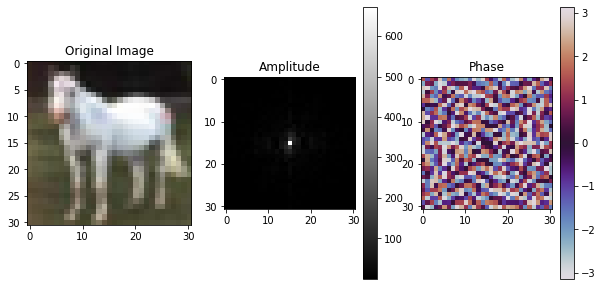

In [ ]:
print(x_test.shape)
img1 = x_test[50]
ft1 = img_2_ft(np.linalg.norm(img1, axis=-1))
r, p = cart_2_pol(ft1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(r, cmap='gray')
plt.title('Amplitude')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(p, cmap='twilight')
plt.title('Phase')
plt.colorbar()
plt.show()

Kind of boring right? Neither the amplitude nor the phase of the fourier transform of our images look particularly meaningful. The amplitude is largely centered around the origin, which makes sense because our image are very low resolution, and so we wouldn't expect there to be many high frequencies. The phase however just sort of looks like noise right?

Well if you look closer at the phase you might start to see something that looks like a pattern. Don't believe me? Well heres what happens if reconstruct the image using only the phase or only the amplitude

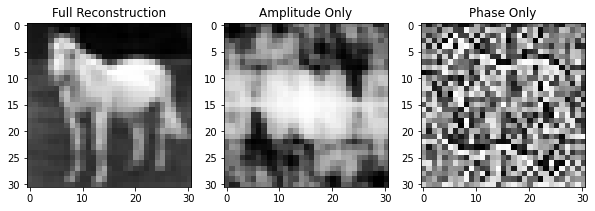

In [ ]:
from skimage import exposure
def hist_eq(img):
    img_cdf, bin_centers = exposure.cumulative_distribution(img)
    return np.interp(img, bin_centers, img_cdf)
img = ft_2_img(ft1)
ft_p = pol_2_cart(r=np.ones(shape=img.shape), theta=p)
ft_r = pol_2_cart(r=r, theta=np.zeros(shape=img.shape))
img_r = hist_eq(ft_2_img(ft_r))
img_p = hist_eq(ft_2_img(ft_p))
plt.figure(figsize=(10, 5))
plt.set_cmap('gray')
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Full Reconstruction')
plt.subplot(1, 3 ,2)
plt.imshow(img_r)
plt.title('Amplitude Only')
plt.subplot(1, 3 ,3)
plt.imshow(img_p)
plt.title('Phase Only')
plt.show()

You can see that reconstructing the image only with the amplitude information results in a reconstruction that looks nothing like the original image. Reconstructing the image with the phase however results it something that almost looks like it has been high pass filtered. You can sort of make out some of the edges. Still don't believe me. Here's the same example with a higher resolution image.

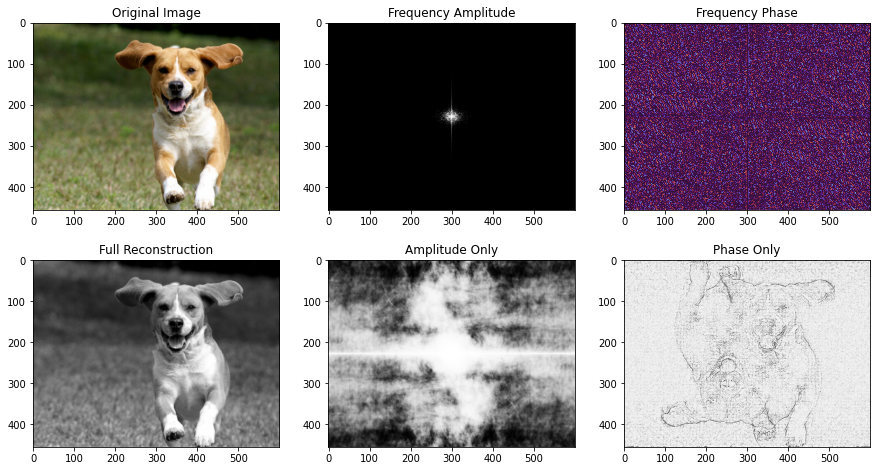

In [ ]:
img2 = imageio.imread('/content/drive/MyDrive/CSC2541/dog.jpg')
ft2 = img_2_ft(np.linalg.norm(img2, axis=-1))
r, p = cart_2_pol(ft2)
plt.figure(figsize=(15, 8))
plt.subplot(2, 3, 1)
plt.imshow(img2)
plt.title('Original Image')
plt.subplot(2, 3, 2)
plt.imshow(hist_eq(r), cmap='gray')
plt.title('Frequency Amplitude')
plt.subplot(2, 3, 3)
plt.imshow(hist_eq(p), cmap='twilight')
plt.title('Frequency Phase')
img = ft_2_img(ft2)
ft_p = pol_2_cart(r=np.ones(shape=img.shape), theta=p)
ft_r = pol_2_cart(r=r, theta=np.zeros(shape=img.shape))
img_r = hist_eq(ft_2_img(ft_r))
img_p = hist_eq(ft_2_img(ft_p))
plt.subplot(2, 3, 4)
plt.imshow(img, cmap='gray')
plt.title('Full Reconstruction')
plt.subplot(2, 3 ,5)
plt.imshow(img_r)
plt.title('Amplitude Only')
plt.subplot(2, 3 ,6)
plt.imshow(img_p)
plt.title('Phase Only')
plt.show()

Now you can clearly see that the phase information is enough to reconstruct the edges of the original image. We know that most image classifiers are heavily reliant on the edges within an image in order to classify it, which is likely why perturbing the data with high frequency noise increased the model error rate more than perturbing it with low frequency noise. But is it the amplitudes of this noise that is important or the phase. In the paper they modify both. Let's see how different augmentations affect each

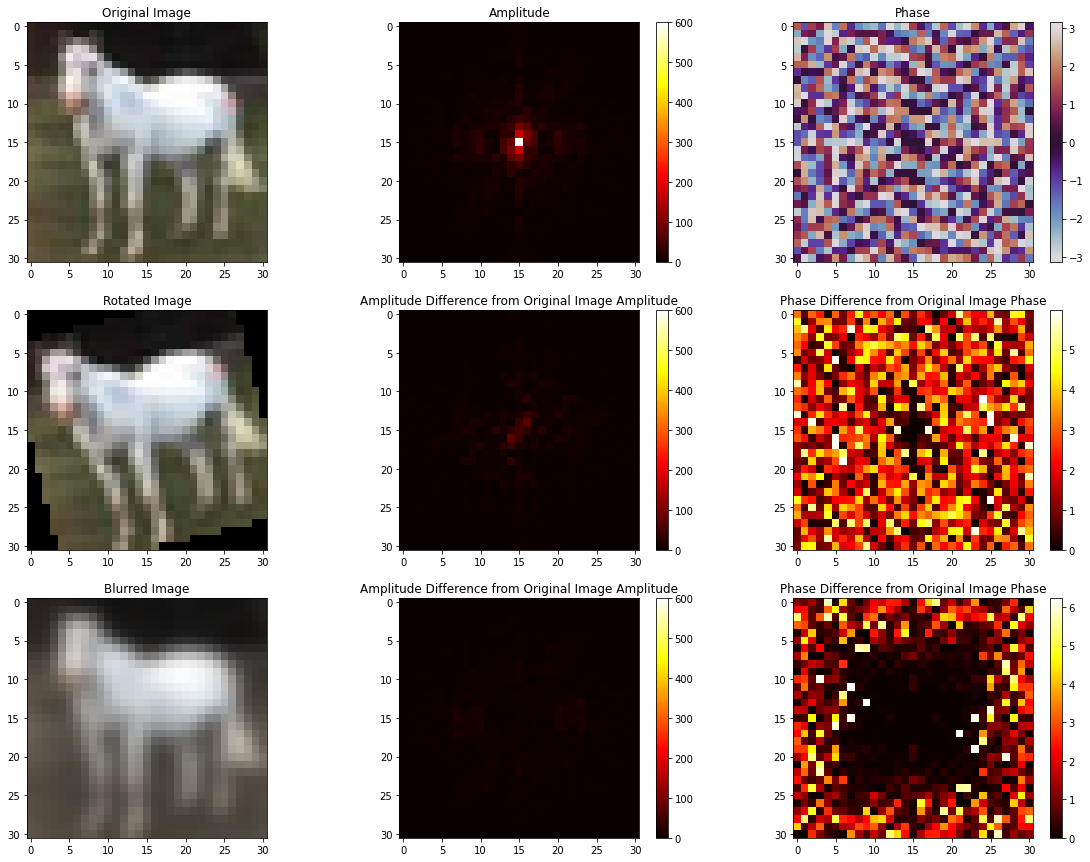

In [ ]:
img_rot = scipy.ndimage.rotate(img1, 15, reshape=False)
ft_rot = img_2_ft(np.linalg.norm(img_rot, axis=-1))
r, p = cart_2_pol(ft1)
plt.figure(figsize=(20, 15))
plt.subplot(3, 3, 1)
plt.imshow(img1)
plt.title('Original Image')
plt.subplot(3, 3, 2)
plt.imshow(r, cmap='hot', vmin=0, vmax=600)
plt.colorbar()
plt.title('Amplitude')
plt.subplot(3, 3, 3)
plt.imshow(p, cmap='twilight')
plt.colorbar()
plt.title('Phase')

r2, p2 = cart_2_pol(ft_rot)
plt.subplot(3, 3, 4)
plt.imshow(img_rot)
plt.title('Rotated Image')
plt.subplot(3, 3, 5)
plt.imshow(abs(r - r2), cmap='hot', vmin=0, vmax=600)
plt.colorbar()
plt.title('Amplitude Difference from Original Image Amplitude')
plt.subplot(3, 3, 6)
plt.imshow(abs(p - p2), cmap='hot')
plt.title('Phase Difference from Original Image Phase')
plt.colorbar()

img_blur = scipy.ndimage.gaussian_filter(img1, sigma=1)
ft_blur = img_2_ft(np.linalg.norm(img_blur, axis=-1))
r3, p3 = cart_2_pol(ft_blur)
plt.subplot(3, 3, 7)
plt.imshow(img_blur)
plt.title('Blurred Image')
plt.subplot(3, 3, 8)
plt.imshow(abs(r-r3), cmap='hot', vmin=0, vmax=600)
plt.colorbar()
plt.title('Amplitude Difference from Original Image Amplitude')
plt.subplot(3, 3, 9)
plt.imshow(abs(p - p3), cmap='hot')
plt.title('Phase Difference from Original Image Phase')
plt.colorbar()
plt.show()

As you can see, rotating the image has a huge effect on the phase. However the amplitudes of the frequencies are only significantly affected for the lowest frequencies. Blurring however has a very different effect. It only changes the phase of the highest frequencies, which are not present in the image anyways. Hence phase information seems to be mostly preserved after a blurring augmentation. These observations can help us understand what different types of augmentations are doing and how they work. Geometrical augmentations (rotation, translation, flipping etc.) change the phase of all the frequencies in the image, which we showed before, contain useful information about the edges in the image. This makes sense as for signals, translation in the time domain corresponds to a phase shift. Perhaps random geometrical transformations work by introducing noise into the phase of the images, which forces the model to learn from the amplitudes of the frequencies as well, which might be more generalizable. The phase diagrams on their own seem pretty noisy when we try to interpret the visually, however you can sometimes identify patterns within them, perhaps this noise helps isolate those patterns in the phase? Further exploration is required. We tried running the commented out code below, but ran into what I think were OOM issues. But it would be interesting to explore if model sensitivity to fourier basis vector noise is altered when the phase of the noise is matched to the phase of that frequency and direction in the image.

In [ ]:
# Keeps breaking kaggle so commenting out for now. Not sure if its an OOM or just kaggle wierdness
# model = VGG_baseline(num_classes=10, training=False)
# metric_fn = get_metrics_fn(metric_functions=[accuracy])
# eval_step = get_eval_fn(model, cross_entropy_loss, metric_fn)

# shape = (x_test.shape[1], x_test.shape[2])
# r = np.zeros(shape)
# a = np.zeros(shape)
# w = np.zeros(shape)

# n = []

# def generate_heatmap(data, model, params, norm=None):
#     x_eval, y_eval = data
#     out_img = np.ndarray((x_eval[0].shape[0], x_eval[0].shape[1]))
#     for row in tqdm.trange(out_img.shape[0]):
#         for column in range(out_img.shape[1]):
#             radius, angle = get_r_theta(row, column, out_img.shape)
#             wavelength = out_img.shape[0]/radius if radius != 0 else None #the middel pixel
#             new_eval_images = add_freq_noise_phase(x_eval, wavelength, angle, norm=norm, rng = jax.random.PRNGKey(10))
#             eval_results = eval((new_eval_images, y_eval), params, eval_step, batch_size=None, rng=jax.random.PRNGKey(10))
#             img[row, column] = eval_results['val_accuracy']
#             r[row, column] = radius
#             a[row, column] = angle
#             w[row, column] = wavelength
#     return out_img

# data = (x_test[1000:2000], y_test[1000:2000]) #error rates are averaged 100 validation images
# hm = generate_heatmap(data, model, params, norm=2)

## Links
---

interesting comment on phase:
https://dsp.stackexchange.com/questions/16995/image-reconstructionphase-vs-magnitude

understanding 2d fourier:
https://thepythoncodingbook.com/2021/08/30/2d-fourier-transform-in-python-and-fourier-synthesis-of-images/